# Starbucks Segmentation : Cleansing & Wrangling

# 1. Dataset

The dataset is a part of Udacity Data Science Nanodegree Capstone project.

Following are three files in the dataset:

1. portfolio.json: contains information about each offer & various attributes related to the offer
2. profile.json: contains metadata about customers
3. transcript.json: contains data related to event such as offer recevied/viewed/completed by a customer

Schema of each of the three files:

1. portfolio.json

    - id (string): alpha-numeric id to uniquely identify each offer
    - offer_type (string): name of the offers (bogo, discount, informational)
    - channels (list of string): channels used by starbucks to send offers ex: web, social
    - duration (int): duration for which the offer will be valid
    - difficulty (int): difficulty associated with each of the offer
    - reward (int): reward associated with each of the offer


2. profile.json

    - id (string): alpha-numeric id to uniquely identify each customer
    - age(int): age of the customer
    - gender(string): gender of the customer
    - became_member_on (int): a single integer that contains date the customer became member on
    - income (float): income of the customer
    
    
3. transcript.json

    - person (string): alpha-numeric id to uniquely identify customer (same as id from profile.json)
    - event (string): contains the event that took place offer recevied/viewed/completed or whether it was transaction
    - value (dict of strings): contains offer id or amount of transaction/reward depending on the type of event
    - time (int): describes when the event occured starts with t=0
    

In [1]:
"Import the required libraries for cleansing, viz & transformation"

#import Segmentation class from helper file
from segmentation import Transformation

#data manipulation library
import pandas as pd
import numpy as np

#visualization libraries
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
#cluster visualization
from yellowbrick.cluster.elbow import kelbow_visualizer

#set graphic properties
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_style("whitegrid")

#manage warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#define the color pallete for viz
starbucks = ["#00704A", "#27251F", "#604c4c", "#eac784", "#362415", "#c38d60"]

In [3]:
def read_json_files(filename):
    '''
    Function takes the filename as input reads the file
    as a pandas dataframe and returns it.
    
    INPUT: 
        filename: string filename ex: profile.csv
    OUTPUT:
        pandas dataframe of the csv file
    '''
    filepath = "data/" + filename
    df = pd.read_json(filepath, lines=True)

    return df

#call the function to read all three files
df_portfolio = read_json_files("portfolio.json")
df_profile = read_json_files("profile.json")
df_transcript = read_json_files("transcript.json")

### Glimpse of the data

In [4]:
#portfolio dataframe
print("Shape of dataframe: " + str(df_portfolio.shape))
df_portfolio.head(3)

Shape of dataframe: (10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed


In [5]:
#profile dataframe
print("Shape of dataframe: " + str(df_profile.shape))
df_profile.head(3)

Shape of dataframe: (17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN


In [6]:
#transcript dataframe
print("Shape of dataframe: " + str(df_transcript.shape))
df_transcript.head(3)

Shape of dataframe: (306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


# 2. Data Cleansing

If the data is incorrect, the output of the algorithm will be affected. When combining multiple data files, there are many opportunities for data to be duplicated or mislabeled. If data is incorrect, outcomes and algorithms are unreliable, even though they may look correct.Therefore, it is essential to fix any inconsistencies such as null values, incorrect date format, duplicate values before moving on the transformation stages. This section addresses such inconsistencies in each of the three data files and fixes them. 

In [7]:
def check_null_values(df):
    '''
    Function to check and generate percentage of null values in the data
    
    INPUT:
        1. df(pandas dataframe): dataframe to check the null values
        
    OUTPUT:
        1. null_percent(series): columns in the dataframe & percentage of null
                                    values in each of the column
    '''
    #calculate null value percent
    null_percent = round(df.isnull().sum() * 100 / len(df), 2)
    
    return null_percent

## 2.1 Portfolio

In [8]:
#check for nulls
check_null_values(df_portfolio)

reward        0.0
channels      0.0
difficulty    0.0
duration      0.0
offer_type    0.0
id            0.0
dtype: float64

Great! There are no null values in the portfolio dataframe. The id column's name however, should be changed to offer_id & the columns have to be rearraged for better interpretation. In addtion, starbucks uses different channels to send different offers to customers. Viusualizing the channels in the dataframe will help to get the general understanding of all the channels used by starbucks to send the offers.

In [9]:
#rename the id column to offer_id
df_portfolio.rename(columns = {"id" : "offer_id"}, inplace=True)

#rearange the columns
col_order = ['offer_id', 'offer_type', 'channels', 'duration', 'difficulty','reward']
df_portfolio = df_portfolio[col_order]
df_portfolio.head(2)

,offer_id,offer_type,channels,duration,difficulty,reward
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,"[email, mobile, social]",7,10,10
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,"[web, email, mobile, social]",5,10,10


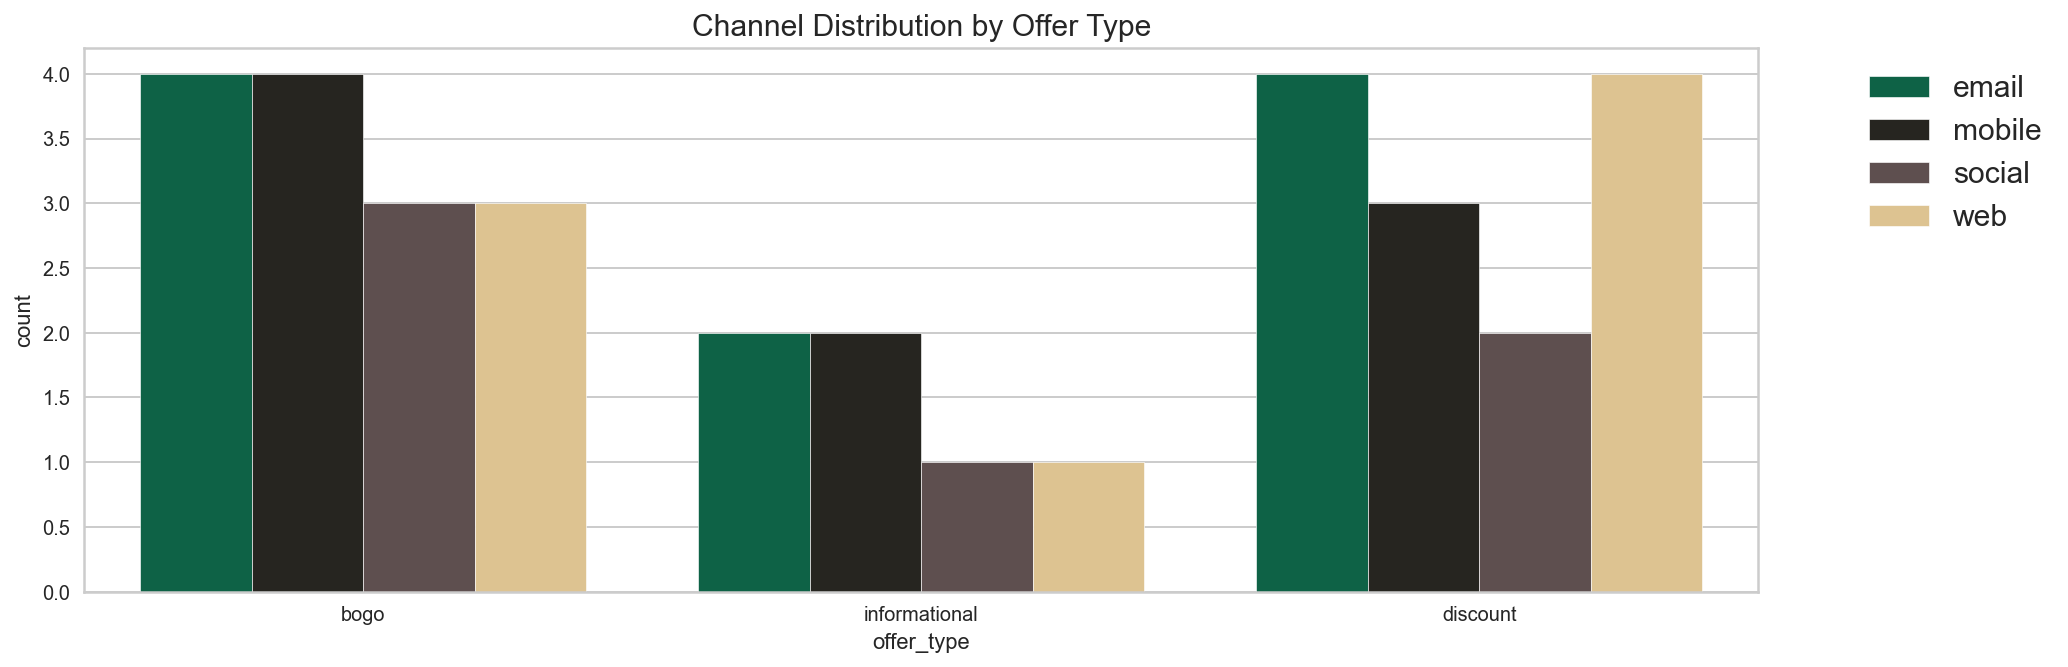

In [10]:
#visualize offer types by different channels
df_channels = df_portfolio[['offer_type', 'channels']].explode('channels')
plt.figure(figsize=(15,5))
plt.title("Channel Distribution by Offer Type", fontsize = 15)
g = sns.countplot(data=df_channels, x = "offer_type", hue="channels", palette=starbucks)
g = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize = 15)

Starbucks uses 4 different channels: email, mobile, social, web to send each of the three offer types. Email appears to be the most consistent channel used across all three offers. While mobile seems to be second favoured channel for sending bogo & informational offers, web is second favoured for the discount offer. 

In [11]:
#mean reward, difficulty & duration for each offer
df_portfolio.groupby(by="offer_type").mean()

,duration,difficulty,reward
offer_type,,,
bogo,6.0,7.50,7.5
discount,8.5,11.75,3.0
informational,3.5,0.00,0.0


Bogo offers seems to have balance between duration, difficulty & rewards whereas the rewards are low for discount offers as compared to their diffculty. Informational offers rightly do not have any rewards associated with them.

## 2.2 Profile

In [12]:
#check for null values
check_null_values(df_profile)

gender              12.79
age                  0.00
id                   0.00
became_member_on     0.00
income              12.79
dtype: float64

12.79% of the gender & income values are null. These values cannot be dropped as 12.79% is a large part of the data. Analysing these values further can uncover some patterns and reasons as to why the data is missing.

In [13]:
#analyze the missing gender values
df_profile[df_profile['gender'].isna()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


An interesting observation here, the customers who have null for gender also have null for income values. In addtion, their age in the dataset is 118 which is unrealistic to have for every single one of them. Before, moving on with imputations, analysing the non-null data will give addtional insights for each of the dimensions.

### Distributions

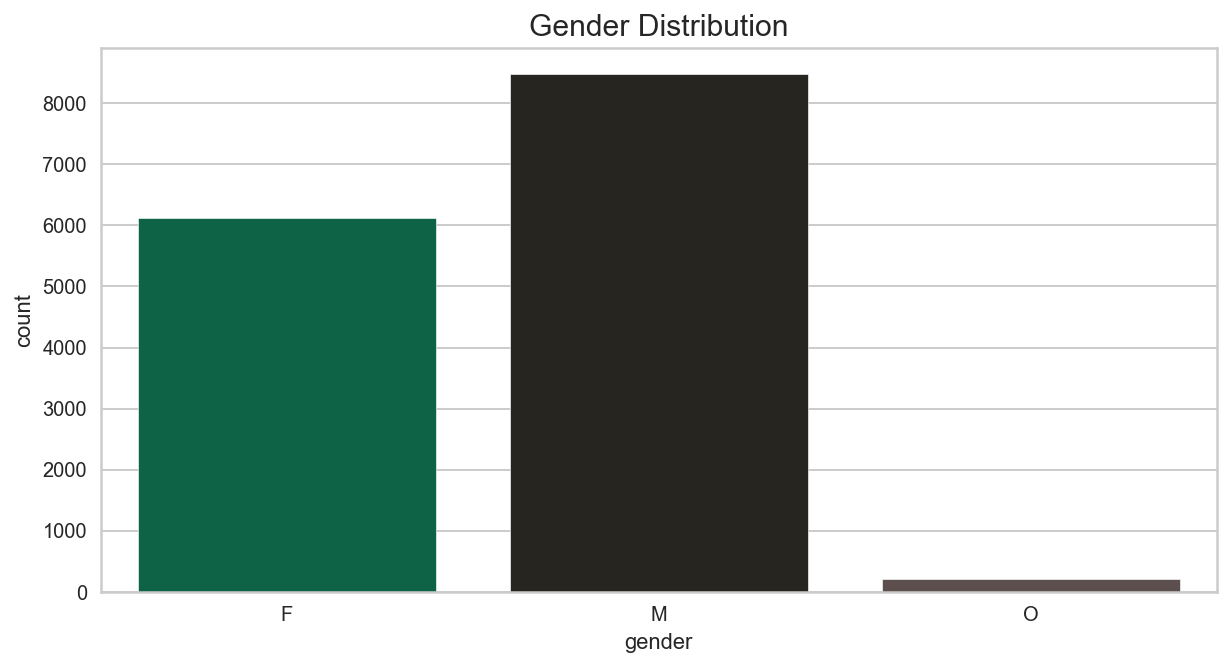

In [14]:
#Gender distribution
bx_plt_df = df_profile[df_profile['age'] != 118]
plt.figure(figsize=(10,5))
plt.title("Gender Distribution", fontsize = 15)
g = sns.countplot(data=bx_plt_df, x = "gender", palette=starbucks)

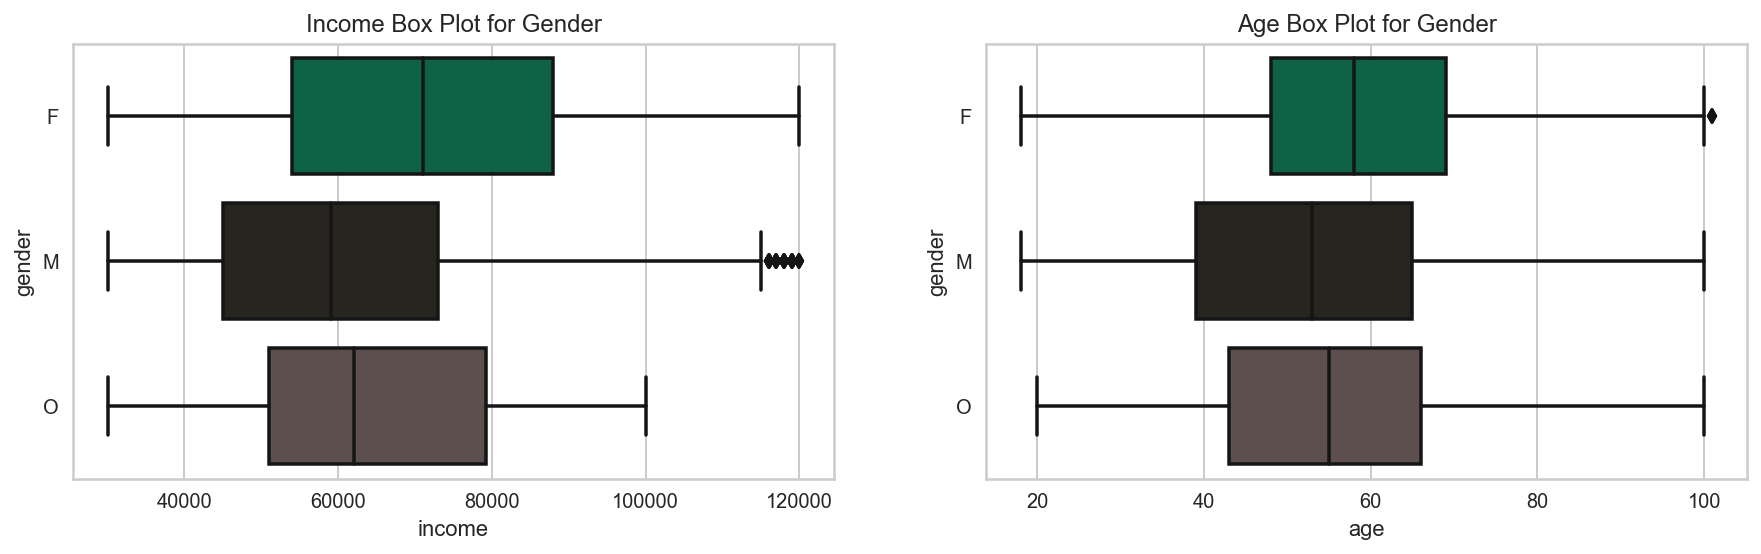

In [15]:
#box plots for income and age according to gender
fig, axs = plt.subplots(ncols=2, figsize=(15,4))
sns.boxplot(x="income", y="gender", data=bx_plt_df, palette=starbucks, ax = axs[0])
sns.boxplot(x="age", y="gender", data=bx_plt_df, palette=starbucks, ax = axs[1])
axs[0].title.set_text('Income Box Plot for Gender')
axs[1].title.set_text('Age Box Plot for Gender')

Majority of the customers are Male followed by Female & Others. Even if that is the case, Female customers have the highest average income & age when compared to other two groups. The average income & age of Male customers is lowest in all three categories. There are few outliers in the income for Male customers and age of Female customers. However, these outliers seem realistic so keeping them as is makes sense.

In [16]:
#fix the date format
df_profile['became_member_on'] = pd.to_datetime(
                                    df_profile['became_member_on'], 
                                    format='%Y%m%d')
df_profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0


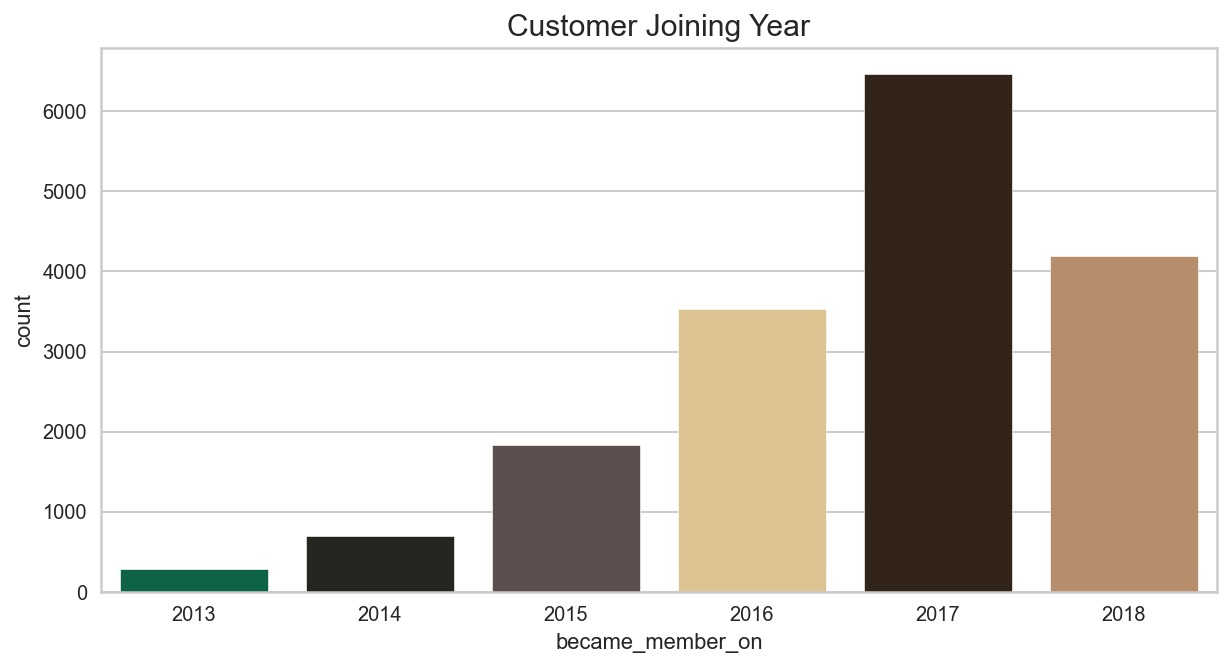

In [17]:
#visuzlize the years customers became members on
plt.figure(figsize=(10,5))
plt.title("Customer Joining Year", fontsize = 15)
g = sns.countplot(x = df_profile.became_member_on.dt.year, palette=starbucks)

In [18]:
#identify lastest few dates in the dataset
df_profile[df_profile.became_member_on.dt.year == 2018] \
            ["became_member_on"] .sort_values().tail(3)

10282   2018-07-26
12902   2018-07-26
1517    2018-07-26
Name: became_member_on, dtype: datetime64[ns]

Number of customers joining over the years have increased except for year 2018. However, this is be due to the fact the data for year 2018 is only till July.

### Imputing the missing values

1. The missing values for gender will be using mode. Since mode for gender variable is Male (M) the mode will be set to mail.
2. For age, 118 will be replaced with nan values.
3. Age & Income will be imputed using the median for Male values.

In [19]:
#Impute Gender
mode = df_profile['gender'].mode().tolist()[0]
df_profile['gender'].fillna(mode, inplace=True)

In [20]:
#Replace age 118 with nan values
df_profile['age'].replace(118, np.nan, inplace=True)

#impute age & income values with mean values of male customers
male_age_mean = round(df_profile[df_profile['gender'] == "M"]['age'].median(), 2)
df_profile['age'].fillna(male_age_mean, inplace=True)
male_income_mean = round(df_profile[df_profile['gender'] == "M"]['income'].median(), 2)
df_profile['income'].fillna(male_income_mean, inplace=True)

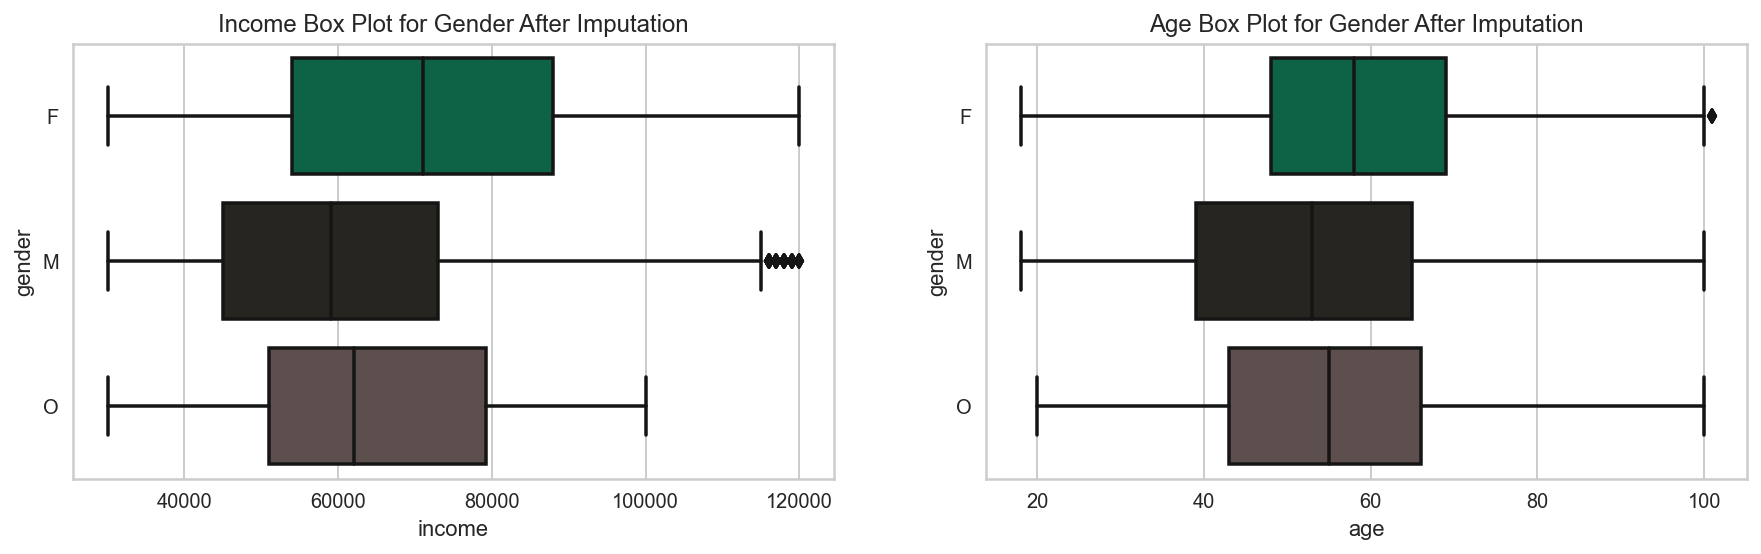

In [21]:
#distribtion after imputation
fig, axs = plt.subplots(ncols=2, figsize=(15,4))
sns.boxplot(x="income", y="gender", data=bx_plt_df, palette=starbucks, ax = axs[0])
sns.boxplot(x="age", y="gender", data=bx_plt_df, palette=starbucks, ax = axs[1])
axs[0].title.set_text('Income Box Plot for Gender After Imputation')
axs[1].title.set_text('Age Box Plot for Gender After Imputation')

## 2.3 Transcripts

In [22]:
#check for null values
check_null_values(df_transcript)

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64

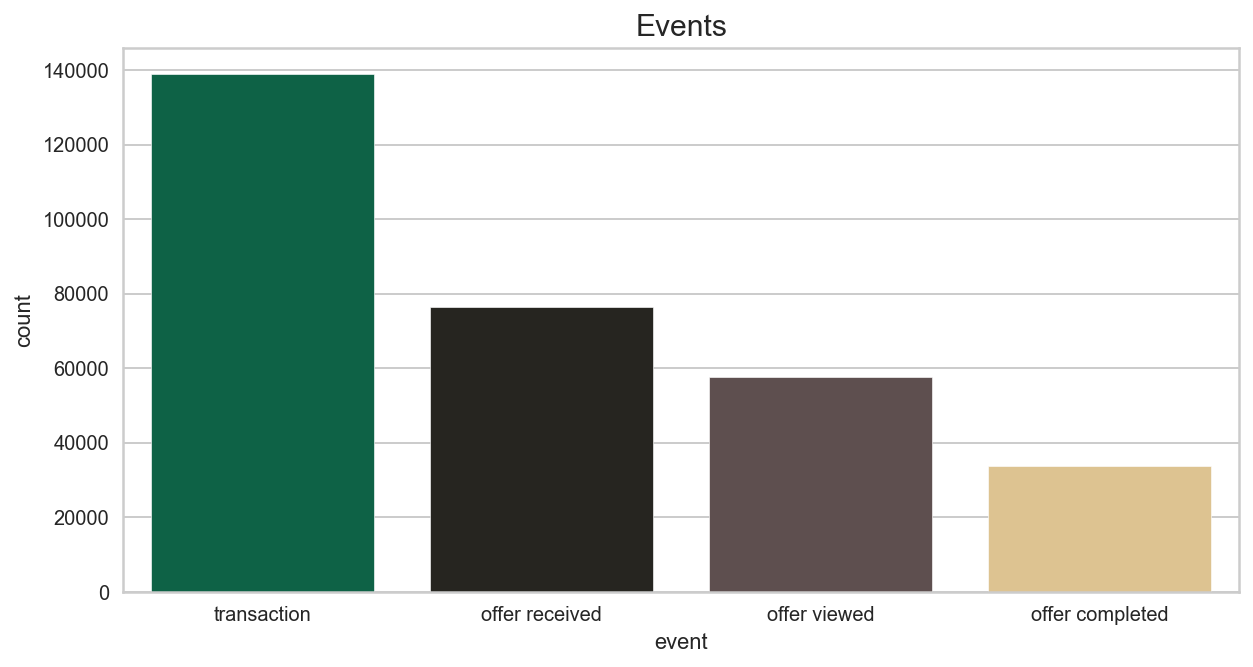

In [23]:
#plot the events
plt.figure(figsize=(10,5))
plt.title("Events", fontsize = 15)
g = sns.countplot(x = df_transcript.event, 
                  order = df_transcript['event'].value_counts().index,
                  palette=starbucks)

1. Transaction event represents some kind of transaction made by the customer. The transaction can either be amount paid by the customer or it can be reward received by the customer. 
2. Offer received event occurs when the customer is sent an offer by starbucks, however, this does not mean the customer will view the offer or complete offer.
3. Offer viewed is when the customer checks out the offer but may or may not opt in for the offer during the time of transaction.
4. Offer completed is when the customer receives the offer, views the offer and opts in during the time of transaction.

In addtion, the "value" column is in dictonary format. This column has to normalized before further analysis.

### Normalizing value column

In [24]:
#normalize the value column
normalized_values = pd.json_normalize(df_transcript['value'])
normalized_values.head(3)

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN


The offer id & the offer_id have to be merged together. The amount represents the amount a customer paid during a transaction while the reward represents the reward amount received by the customer after the offer.

In [25]:
#merge the offer id & offer_id column
normalized_values['id_values'] = normalized_values['offer id']\
                                    .fillna(normalized_values['offer_id'])

normalized_values.drop(['offer id', 'offer_id'], inplace=True, axis = 1)
normalized_values.head(3)

,amount,reward,id_values
0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,NaN,NaN,2906b810c7d4411798c6938adc9daaa5


In [26]:
#combine the normalized values with the transcript data
df_transcript.drop(['value'], inplace = True, axis = 1)
df_transcript['offer_id'] = normalized_values['id_values']

#combine reward and amount
df_transcript['amount'] = normalized_values['amount'].fillna(0)
df_transcript['rewards'] = normalized_values['reward'].fillna(0)

df_transcript.head(3)

,person,event,time,offer_id,amount,rewards
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0


In [27]:
#check for null values
check_null_values(df_transcript)

person       0.00
event        0.00
time         0.00
offer_id    45.33
amount       0.00
rewards      0.00
dtype: float64

The null values in the offer_id can be a result of the customer doing a transaction instead of receiving/vieweing/completing an offer. Therefore, null values should be checked for records where the event is related to an offer.

In [28]:
check_null_values(df_transcript[df_transcript['event'] != 'transaction'])

person      0.0
event       0.0
time        0.0
offer_id    0.0
amount      0.0
rewards     0.0
dtype: float64

### Multiple Offer Instances

There is possiblity that the customer recevied/viewed same offer multiple times. This has to be investigated as it will have impact on the analysis further.

In [29]:
received_offers = df_transcript[df_transcript['event'] == 'offer received']
received_offers.groupby(["person", "offer_id"])['offer_id'] \
                .count().sort_values(ascending = False).head()

person                            offer_id                        
2ea50de315514ccaa5079db4c1ecbc0b  fafdcd668e3743c1bb461111dcafc2a4    5
6d2db3aad94648259e539920fc2cf2a6  f19421c1d4aa40978ebb69ca19b0e20d    5
43a50d7e5c8547a9aa1ec31291b9fc30  0b1e1539f2cc45b7b9fa7c272da2e1d7    5
23d67a23296a485781e69c109a10a1cf  5a8bc65990b245e5a138643cd4eb9837    5
eece6a9a7bdd4ea1b0f812f34fc619d6  5a8bc65990b245e5a138643cd4eb9837    5
Name: offer_id, dtype: int64

Since a customer can receive/view/complete an offer multiple times the offer_id is no longer a valid unique identifier for each person. The offer_id column therefore has to be processed to make each offer for each person unique. 
Example: if a customer receives "fafdcd668e3743c1bb461111dcafc2a4" offer twice then the offer will marked as "fafdcd668e3743c1bb461111dcafc2a4_0" & "fafdcd668e3743c1bb461111dcafc2a4_1" respectively. 

In [30]:
'''
Define two functions to process new offer ids
1. To generate unique ids for each offer by person
2. To merge the unique ids with each of the offers by person
'''

def process_ids(offer_df, event_value):
    """
    Function to generate indicators by getting cumulative count for ids from the repeated ids
    
    INPUT: 
        1. offer_df(pandas dataframe): unprocessed dataframe containing non-unique offers
        2. event_value(string): event for which unique ids have to be generated
        
    OUTPUT: series with unique ids and person as the index
    """
    #group the dataframe by person and offer_ids and get cumlative count
    data = offer_df[offer_df.event == event_value] \
            .groupby(['person', 'offer_id']).cumcount()
    
    
    return data

def get_unique_offer_ids(offer_df, event_list):
    """
    Function to get the unique id indicators from process_ids function &
    append them to the original ids and store the result into a new column.
    
    INPUT: 
        1. offer_df(pandas dataframe): unprocessed dataframe containing non-unique offers
        2. event_list(list): list of three events(received, completed, viewed)
    
    OUTPUT: Processed offer_df with new column having unique ids for each user
    """
    #loop through the events list and process the ids
    for e in event_list:
        colname = "new_" + e.split()[1]
        offer_df[colname] = process_ids(offer_df, e)
        
    #combine into a single column
    offer_df['new_ids'] = offer_df[['new_received', 'new_viewed', 'new_completed']] \
                                .max(axis = 1).values
    offer_df['new_ids'] = offer_df["new_ids"].astype('Int32')
    #create new offer_ids
    offer_df['new_offer_ids'] = offer_df['offer_id'] + "_" + offer_df['new_ids'].astype(str)
    #return the updated dataframe
    offer_df = offer_df[['person', 'offer_id', "new_offer_ids", 'event', 'time']]
    
    return offer_df

#list of events
events = ['offer received', 'offer viewed', 'offer completed']
#call the function get_unique_offer_ids to get unique offer ids
offer_df = get_unique_offer_ids(df_transcript, events)

offer_df.head(3)

,person,offer_id,new_offer_ids,event,time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9_0,offer received,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7_0,offer received,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5_0,offer received,0


In [31]:
#check if there are any repeated offer_ids
received_offers = offer_df[offer_df['event'] == 'offer received']
received_offers.groupby(["person", "new_offer_ids"])['offer_id'] \
                .count().sort_values(ascending = False).head()

person                            new_offer_ids                     
0009655768c64bdeb2e877511632db8f  2906b810c7d4411798c6938adc9daaa5_0    1
a93b655903f249c7bc074c0b4b69f52e  2906b810c7d4411798c6938adc9daaa5_0    1
a938c3fd37a74118be0f298145aed07d  2906b810c7d4411798c6938adc9daaa5_1    1
                                  2906b810c7d4411798c6938adc9daaa5_0    1
                                  0b1e1539f2cc45b7b9fa7c272da2e1d7_1    1
Name: offer_id, dtype: int64

### Padding time column

Now there are unique offer ids for each person. The time column represents time in hours and starts with t = 0. However, going forward, 0 will be used to to fill null values in other words the value of 0 is to indicate nothing. Therefore, the time dimension has to be padded with extra 0.5 to make the t=0 relevant for further analysis.

In [32]:
#add extra 0.5 to the time
offer_df['time'] = offer_df['time'] + 0.5
offer_df.head(2)

,person,offer_id,new_offer_ids,event,time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9_0,offer received,0.5
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7_0,offer received,0.5


In [33]:
#check for null values
check_null_values(offer_df)

person            0.00
offer_id         45.33
new_offer_ids    45.33
event             0.00
time              0.00
dtype: float64

## 3. Data Wrangling 

Data Wrangling is the process of selecting & transforming the data into format suitable for analytical purpose. This step will take considerable amount of time and will use the cleaned data from the data cleansing section. Since there are considerable amount of transformations to be performed, to keep things clean, I have defined a class "Transformation" in another file helper.py which will include all the relevant functions to perform the required transformations.

### Compute times for each event

In [34]:
"One-hot encode the events from offers dataframe"
#get the dummies
offer_df = pd.get_dummies(data = offer_df, columns=["event"])
#rename the columns
offer_df = offer_df.rename(columns = {
                        "event_offer completed" : "offer_completed", 
                        "event_offer received" : "offer_received",
                        "event_offer viewed" : "offer_viewed"})

offer_df.head(3)

,person,offer_id,new_offer_ids,time,offer_completed,offer_received,offer_viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9_0,0.5,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7_0,0.5,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5_0,0.5,0,1,0,0


Now that the event dimension is one hot encoded the next step is to get the received-viewed-completed time for each of the unique offer by person. To do this the get_offer_times function from the Transformation class will used.

In [35]:
#call the function to get individual times
w_offer_df = Transformation.get_offer_time(offer_df)
w_offer_df.head(3)

,person,new_offer_ids,received_time,viewed_time,completed_time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5_0,576.5,0.0,576.5
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed_0,336.5,372.5,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837_0,168.5,192.5,0.0


In [36]:
check_null_values(w_offer_df)

person            0.0
new_offer_ids     0.0
received_time     0.0
viewed_time       0.0
completed_time    0.0
dtype: float64

### Process Valid Transactions

For an offer transaction to be considered valid it has to satisfy the following conditions:
   1. For an offer to be counted as “viewed” & "completed" it had to be viewed before offer expiration date.
   2. An invalid offer completed transaction is an offer completed status without beign viewed.
   3. An invalid offer completed transaction is also an offer completed without viewing the transaction.
   4. An invalid viewed offer transaction would be an offer viewed before even receiving the offer.
   
In order to filter out these invalid offer transactions,get_valid_offers from the Transformation class will be used. However, before that a new columns has to be calculated "end_time" representing the offer end time for each individual customer. End time of the offer is offer received time + the duration of the offer. But the duration is from portfolio data & the column is in the days format, this column has to be convert to hours to be consistent with other time format before merging the frame with w_offer_df.

In [37]:
#convert the duration to hours from days
df_portfolio['duration'] = df_portfolio['duration'] * 24

#convert the ids back to their original form
w_offer_df['offer_id'] = w_offer_df['new_offer_ids'].str.split("_").str[0]
#merge the duration column with the w_offer_df dataframe
m_offer_df = w_offer_df.merge(
                df_portfolio[['offer_id', 'duration', 'offer_type']],
                on ="offer_id",
                how="left")

#rearange the columns
colnames = [
    'person', 'offer_id', 'new_offer_ids','offer_type', 
    'received_time','viewed_time','completed_time', 'duration']
m_offer_df = m_offer_df[colnames]

m_offer_df.head(1)

,person,offer_id,new_offer_ids,offer_type,received_time,viewed_time,completed_time,duration
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5_0,discount,576.5,0.0,576.5,168


In [38]:
#calculate the offer end time
m_offer_df['end_time'] = m_offer_df['received_time'] \
                        + m_offer_df['duration']
#drop the duration column
m_offer_df.drop("duration", inplace=True, axis = 1)

#call the function filter out the invalid offers
print("Shape of dataframe before filtering: " + str(m_offer_df.shape))
m_offer_df = Transformation.get_valid_offers(m_offer_df)

print("Shape of dataframe after filtering: " + str(m_offer_df.shape))
m_offer_df.head(3)

Shape of dataframe before filtering: (76277, 8)
Shape of dataframe after filtering: (66277, 8)


,person,offer_id,new_offer_ids,offer_type,received_time,viewed_time,completed_time,end_time
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed_0,informational,336.5,372.5,0.0,432.5
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837_0,informational,168.5,192.5,0.0,240.5
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d_0,bogo,168.5,216.5,0.0,288.5


### View Rate & Completion Rate

The aim is to wrangle data pertaining to each customer so that the customers can be segmented accordingly later. Therefore, each of the calculations should be merged with assoicated customers in the profile dataframe. Setting customer id to index will help to make it easier. 

In [39]:
#rename id in profile dataframe and set it as the index
df_profile.rename(columns={"id" : "person"}, inplace=True)
customer_df = df_profile.set_index("person")
print("Shape of the dataframe is: " + str(customer_df.shape))
customer_df.head(2)

Shape of the dataframe is: (17000, 4)


,gender,age,became_member_on,income
person,,,,
68be06ca386d4c31939f3a4f0e3dd783,M,53.0,2017-02-12,59000.0
0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0


Next step is to calculate conversion rate & view rate for each offer as well as total offers by customers. The get_offer_rate function from the Transformation class will be used to calculate these rates for each of the customers. The function will calculate rates for each individual customer and merge them with the customer dataframe. These rates are caculated as follows:
1. View Rate = offers viewed on time / offers recevied 
2. Conversion Rate = offers completed on time / offers viewed on time

In [40]:
#get all the rates
rated_cust_df = Transformation.get_offer_rates(m_offer_df, customer_df)

print("Shape of the dataframe is: " + str(rated_cust_df.shape))
rated_cust_df.head(3)

Shape of the dataframe is: (17000, 10)


,gender,age,became_member_on,income,informational_vr,informational_cr,bogo_vr,bogo_cr,discount_vr,discount_cr
person,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,M,53.0,2017-02-12,59000.0,0.0,0.0,0.0,0.0,1.0,0.4
0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,0.0,0.0,0.0,0.0,0.0,0.0
38fe809add3b4fcf9315a9694bb96ff5,M,53.0,2018-07-12,59000.0,1.0,0.0,1.0,0.0,0.0,0.0


### Count of each event for each offer

Each individual event recevied/viewed/completed will be counted against each offer type bogo, discount, informational. In addtion, informational offers do not have any completed event assosiated to them, since their sole purpuse is to convey information they only go through the received and viewed phase.

In [41]:
#get counts of each event for each offer
rated_cust_df = Transformation.get_offer_counts(m_offer_df, rated_cust_df)

print("Shape of the dataframe is: " + str(rated_cust_df.shape))
rated_cust_df.head(3)

Shape of the dataframe is: (17000, 18)


,gender,age,became_member_on,income,informational_vr,informational_cr,bogo_vr,bogo_cr,discount_vr,discount_cr,bogo_received_cnt,bogo_viewed_cnt,bogo_completed_cnt,discount_received_cnt,discount_viewed_cnt,discount_completed_cnt,informational_received_cnt,informational_viewed_cnt
person,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,M,53.0,2017-02-12,59000.0,0.0,0.0,0.0,0.0,1.0,0.4,0.0,0.0,0.0,5.0,5.0,2.0,0.0,0.0
0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
38fe809add3b4fcf9315a9694bb96ff5,M,53.0,2018-07-12,59000.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


### Process Transaction Data

In [42]:
#get total amount spent, total amount rewarded & total transactions
rated_cust_df = Transformation.process_transaction_data(df_transcript, rated_cust_df)

print("Shape of the dataframe is: " + str(rated_cust_df.shape))
rated_cust_df.head(3)

Shape of the dataframe is: (17000, 21)


,gender,age,became_member_on,income,informational_vr,informational_cr,bogo_vr,bogo_cr,discount_vr,discount_cr,...,bogo_viewed_cnt,bogo_completed_cnt,discount_received_cnt,discount_viewed_cnt,discount_completed_cnt,informational_received_cnt,informational_viewed_cnt,total_amount,total_rewards,total_transactions
person,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,M,53.0,2017-02-12,59000.0,0.0,0.0,0.0,0.0,1.0,0.4,...,0.0,0.0,5.0,5.0,2.0,0.0,0.0,20.40,5.0,9.0
0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,77.01,5.0,3.0
38fe809add3b4fcf9315a9694bb96ff5,M,53.0,2018-07-12,59000.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,14.30,0.0,6.0


In [43]:
#get the bogo & discount rewards
m_transcripts = df_transcript.merge(
                    df_portfolio[['offer_id', 'offer_type']], 
                    how = "left", 
                    on="offer_id")
#call the fucntion
rated_cust_df = Transformation.process_rewards(m_transcripts, rated_cust_df)

print("Shape of the dataframe is: " + str(rated_cust_df.shape))
rated_cust_df.head(3)

Shape of the dataframe is: (17000, 23)


,gender,age,became_member_on,income,informational_vr,informational_cr,bogo_vr,bogo_cr,discount_vr,discount_cr,...,discount_received_cnt,discount_viewed_cnt,discount_completed_cnt,informational_received_cnt,informational_viewed_cnt,total_amount,total_rewards,total_transactions,bogo_rewards,discount_rewards
person,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,M,53.0,2017-02-12,59000.0,0.0,0.0,0.0,0.0,1.0,0.4,...,5.0,5.0,2.0,0.0,0.0,20.40,5.0,9.0,0.0,5.0
0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,77.01,5.0,3.0,5.0,0.0
38fe809add3b4fcf9315a9694bb96ff5,M,53.0,2018-07-12,59000.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,14.30,0.0,6.0,0.0,0.0


In [44]:
#call the fucntion
rated_cust_df = Transformation.process_event_averages(m_transcripts, rated_cust_df)

print("Shape of the dataframe is: " + str(rated_cust_df.shape))
rated_cust_df.head(3)

Shape of the dataframe is: (17000, 27)


,gender,age,became_member_on,income,informational_vr,informational_cr,bogo_vr,bogo_cr,discount_vr,discount_cr,...,informational_viewed_cnt,total_amount,total_rewards,total_transactions,bogo_rewards,discount_rewards,avg_amount,avg_rewards,avg_bogo_rewards,avg_discount_rewards
person,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,M,53.0,2017-02-12,59000.0,0.0,0.0,0.0,0.0,1.0,0.4,...,0.0,20.40,5.0,9.0,0.0,5.0,2.0,1.0,0.0,0.416667
0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,77.01,5.0,3.0,5.0,0.0,26.0,2.0,2.5,0.000000
38fe809add3b4fcf9315a9694bb96ff5,M,53.0,2018-07-12,59000.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,14.30,0.0,6.0,0.0,0.0,2.0,0.0,0.0,0.000000


### One-Hot Encode Gender & Year

The gender column has three values : Male, Female & Other which will be one hot encoded to have their own columns with 0 for no and 1 for yes as the indicators. In addition, there is 6 years worth of data from 2012-2018, this will also be one hot encoded.

In [45]:
#call the fucntion
rated_cust_df = Transformation.one_hot_encode(rated_cust_df)

print("Shape of the dataframe is: " + str(rated_cust_df.shape))
rated_cust_df.head(3)

Shape of the dataframe is: (17000, 34)


,age,income,informational_vr,informational_cr,bogo_vr,bogo_cr,discount_vr,discount_cr,bogo_received_cnt,bogo_viewed_cnt,...,avg_discount_rewards,gender_F,gender_M,gender_O,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
person,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,53.0,59000.0,0.0,0.0,0.0,0.0,1.0,0.4,0.0,0.0,...,0.416667,0,1,0,0,0,0,0,1,0
0610b486422d4921ae7d2bf64640c50b,55.0,112000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1,0,0,0,0,0,0,1,0
38fe809add3b4fcf9315a9694bb96ff5,53.0,59000.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.000000,0,1,0,0,0,0,0,0,1


In [46]:
check_null_values(rated_cust_df)

age                           0.0
income                        0.0
informational_vr              0.0
informational_cr              0.0
bogo_vr                       0.0
bogo_cr                       0.0
discount_vr                   0.0
discount_cr                   0.0
bogo_received_cnt             0.0
bogo_viewed_cnt               0.0
bogo_completed_cnt            0.0
discount_received_cnt         0.0
discount_viewed_cnt           0.0
discount_completed_cnt        0.0
informational_received_cnt    0.0
informational_viewed_cnt      0.0
total_amount                  0.0
total_rewards                 0.0
total_transactions            0.0
bogo_rewards                  0.0
discount_rewards              0.0
avg_amount                    0.0
avg_rewards                   0.0
avg_bogo_rewards              0.0
avg_discount_rewards          0.0
gender_F                      0.0
gender_M                      0.0
gender_O                      0.0
year_2013                     0.0
year_2014     

In [47]:
#save the processed file as csv
rated_cust_df.to_csv("data/customers.csv")